In [106]:
import psycopg2
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
conn = psycopg2.connect("dbname=postgres user=postgres password=your-password-here host=172.17.0.2")
cur = conn.cursor()

# Application layer brekage

## by provider?

In [16]:
def rollback ():
    conn.commit()

In [54]:
def get_market (market_name):
    '''
    Gets all data on market_name YTD
    '''
    q = f'''
    SELECT
      name,
      jurisdiction_alpha2,
      marketshare
    FROM provider_marketshare
    WHERE
      time between '2021-01-01' and '2021-06-20' AND
      market = '{market_name}' AND
      marketshare > 0 AND
      jurisdiction_alpha2 is not NULL
    '''
    rollback()
    cur.execute(q)
    results = cur.fetchall()
    market = pd.DataFrame(results, columns=['name', 'jurisdiction_alpha2', 'marketshare'])
    market.marketshare = market.marketshare.astype(float)
    return market

In [55]:
m = get_market('dns-server')

In [57]:
m.groupby('name').mean()

,marketshare
name,
1984 Hosting,0.000110
A2 Hosting,0.003256
AT&T,0.000375
Aerotek,0.001997
Afraid,0.000315
...,...
Yandex,0.004747
cdmon,0.000996
easyDNS Group,0.001006


In [131]:
from typing import Callable

markets = [
    'dns-server',
    'proxy',
    'ssl-certificate',
    'data-centers',
#     'server-location',
    'web-hosting',
    'top-level-domain',
]

def max_extent (transformer: Callable[[pd.DataFrame], pd.DataFrame], join_on):
    ms = []
    for market in markets:
        m = get_market(market)
        m = transformer(m)
        m = m.rename({'marketshare': market}, axis=1)
        ms.append(m)
        
    t = ms[0]
    for i, m_df in enumerate(ms[1:]):
        t = t.merge(ms[i+1], how='outer', left_on=join_on, right_on=join_on)
        
    max_extent = t.max(axis=1).sort_values(ascending=False)
    return max_extent

In [132]:
fn = lambda m: m.groupby('name').mean() 
powers = max_extent(fn, 'name')

<AxesSubplot:xlabel='name'>

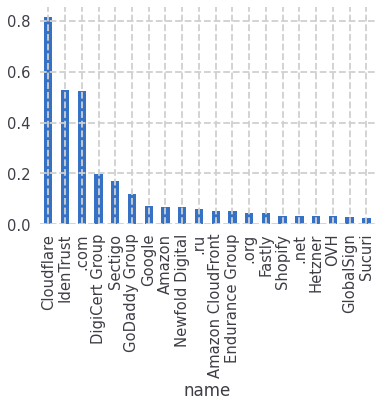

In [133]:
powers[:20].plot.bar()

## for each jurisdiction?

In [134]:
fn = lambda m: m.groupby(['name', 'jurisdiction_alpha2']).mean().groupby('jurisdiction_alpha2').sum()
powers = max_extent(fn, 'jurisdiction_alpha2')

<AxesSubplot:xlabel='jurisdiction_alpha2'>

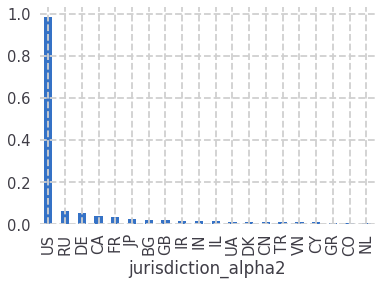

In [137]:
powers[:20].plot.bar()